# Exploring Image Data

# Business Understanding (20 Points)¶

## Overview
This dataset is collected from Guangzhou Women and Children’s Medical Center, Guangzhou, and consists of X-ray images of children age 1-5, some of whom had bacterial or viral pneumonia.  The images are x-rays of the chest and have been labeled by two different doctors---with a third the tiebreaker if the two disagreed.  The original images are in different size, so we resized each image to 160x240 pixels jpeg and converted them into grayscale images.  The following graph is from the last page from the Cell Paper: "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning" shows the distinction between a normal lung, a lung with bacterial pneumonia, and a lung with viral pneumonia.
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia![image.png](attachment:image.png)

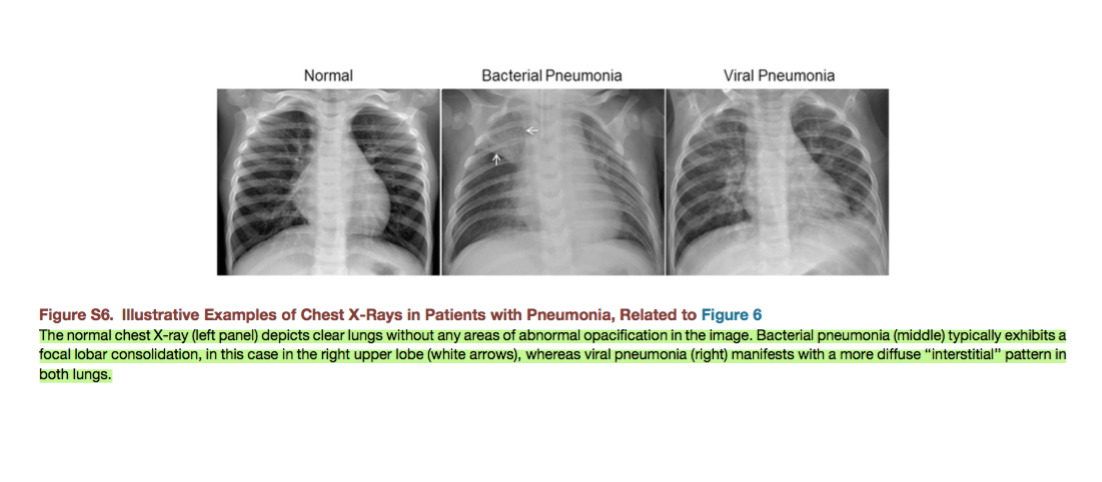

In [128]:
from IPython.display import Image
Image(filename = ".../Lung_Classification.png" )

## Purpose
The purpose of this dataset was to develop an artificial neural network that will be able to distinguish between children with pneumonia in order to assist doctors in making the right decision.  There are three different classifications: normal, pneumonia-bacterial, and pneumonia-viral.  The cell paper, "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning"'s focus is to use transfer learning which is a technique to train a neural network with a relatively small number of images, (Kermany 1122).  For us, our purpose will be to classify the aforementioned three types for a preliminary screening.  As such, the kids will still receive medial care and a second opinion from a doctor so the stakes are not quite as high for our algorithm.




## Prediction Task
The prediction task for this algorithm is similar prediction task that the data was collected for: to distinguish between children with pneumonia and children without pneumonia.  This algorithm would be used by hospitals who have an x-ray machine and who serve children between the ages of 1-5.  Though this data was screened by Chinese children, it can probably be used for children of other nationalities as well.  

## Importance
According to the Cell Paper, data collected by the World Health organization shows that pneumonia kills approximately 2 million children under 5 years old every year (though most of these deaths occur in Southeast asia or Africa). (Kermany 1127)   Since chest x-rays are common and can be used to identify between kids with pneumonia and kids without pneumonia, x-rays were chosen as the method of choice.  If we could develop an accurate and quick classifier, it might be able to be used wherever x-rays are used.  If developed, such an algorithm could be used by nurses and would not require a doctor to analyze the chest x-ray images.  This technique would just save Doctors' time and, potentially, the children who are suffering from pneumonia.  Th algorithm would successfully screen kids with pneumonia and direct them to the needed medical care: antibiotics if the child had bacterial pneumonia, supportive care if the child had viral pneumonia, and discharge if the child does not have pneumonia.


## Desired Accuracy of Classifier

In order for our algorithm to be useful, it would have to be better than the neural net algorithm that has already been created using the same data in some way.  This could mean that our algorithm achieves a greater accuracy than their 93 % and that the area under the ROC curve for our algorithm is better than the area under the ROC curve, (Kermany 1127). This should be possible as we are attempting to solve an easier problem: just separating kids with pneumonia from kids without.  The ROC curve is a way to measure the performance of the algorithm by graphing the true positive rate vs. the false positive rate.  The higher to the left the algorithm line is the better the algorithm is.  The algorithm in the paper achieved the following ROC curve:   

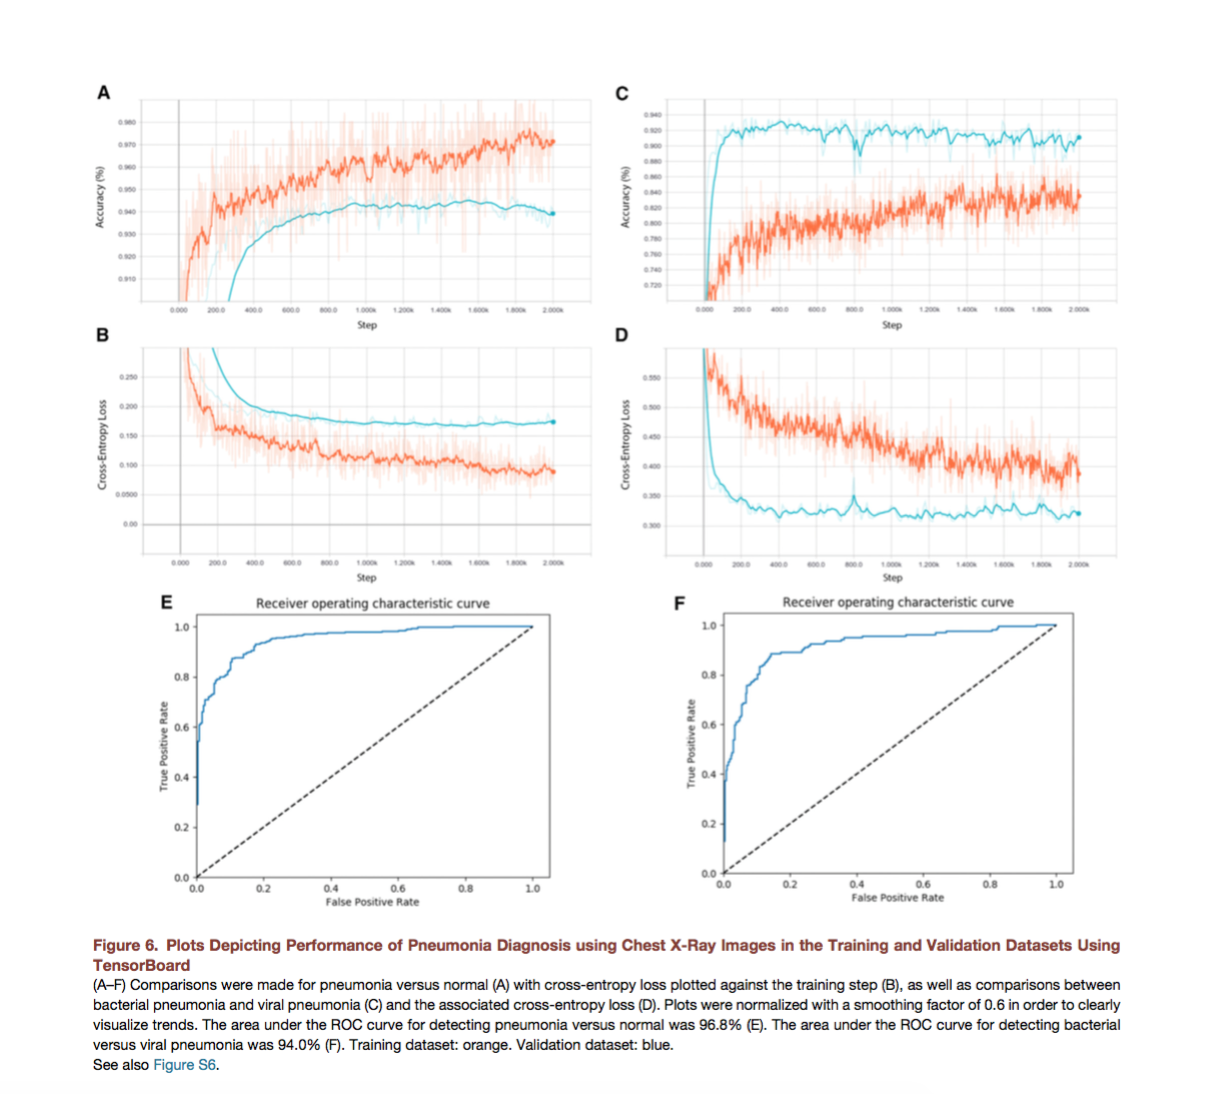

In [129]:
Image(filename = ".../ROC_Curve.png" )

## False Positive vs False Negative Trade-off
In all classification problems, it is important to consider which is worse: false positives or false negatives.  In this case, we will define a false positive as when the algorithm predicts that a child has pneumonia even when he or she doesn’t.  A false negative is when the classivier predicts that the child does not have pneumonia even when the child does.  In this case, it is clear that we want to limit the amount of false negatives and instead have more false positives.  If there is a false positive, all that will happen is that the child will go under more supervised care—if the child does not have pneumonia, this will probably be found with time.  If there is a false negative, though, the child will potentially leave the hospital even though he or she has pneumonia. Clearly, we will try to have more false positives than false negatives in this case.

# Citation for Business Understanding

Kermany, D., Goldbaum, M., Cai, W., Valentim, C., Liang, H., Baxter, S., McKeown, A., Yang, G., Wu, X., Yan, F., Dong, J., Prasadha, M., Pei, J., Ting, M., Zhu, J., Li, C., Hewett, S., Dong, J., Ziyar, I., Shi, A., Zhang, R., Zheng, L., Hou, R., Shi, W., Fu, X., Duan, Y., Huu, V., Wen, C., Zhang, E., Zhang, C., Li, O., Wang, X., Singer, M., Sun, X., Xu, J., Tafreshi, A., Lewis, M., Xia, H. and Zhang, K. (2018). Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell, 172(5), pp.1122-1131.e9.

Kaggle Dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


# Data Preparation (10 points total)

## Import required modules

In [2]:
#!pip install opencv-python
import numpy as np
import pandas as pd
import os, sys
import cv2 
from tqdm import tqdm 
import skimage
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Read image data from folder

In [3]:
folder1 = ".../chest_train/NORMAL/"
normal = [f for f in os.listdir(folder1) if os.path.isfile(os.path.join(folder1, f))]
folder2 = ".../chest_train/PNEUMONIA/"
pneumonia = [f for f in os.listdir(folder2) if os.path.isfile(os.path.join(folder2, f))]
folder = ".../chest_train/"
chest = normal + pneumonia
print("Working with {0} images".format(len(chest)))

Working with 5218 images


## Images examples

We displayed some images from both groups.

person131_virus_265.jpeg


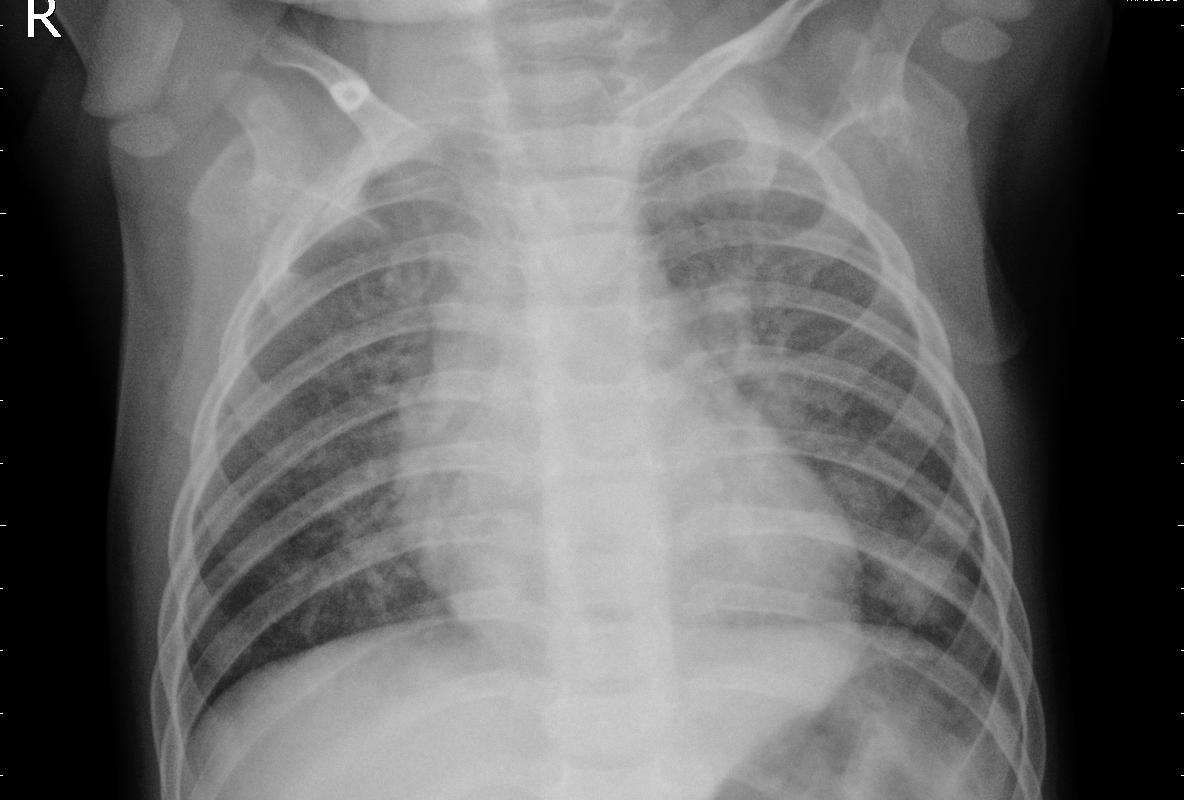

person1391_bacteria_3536.jpeg


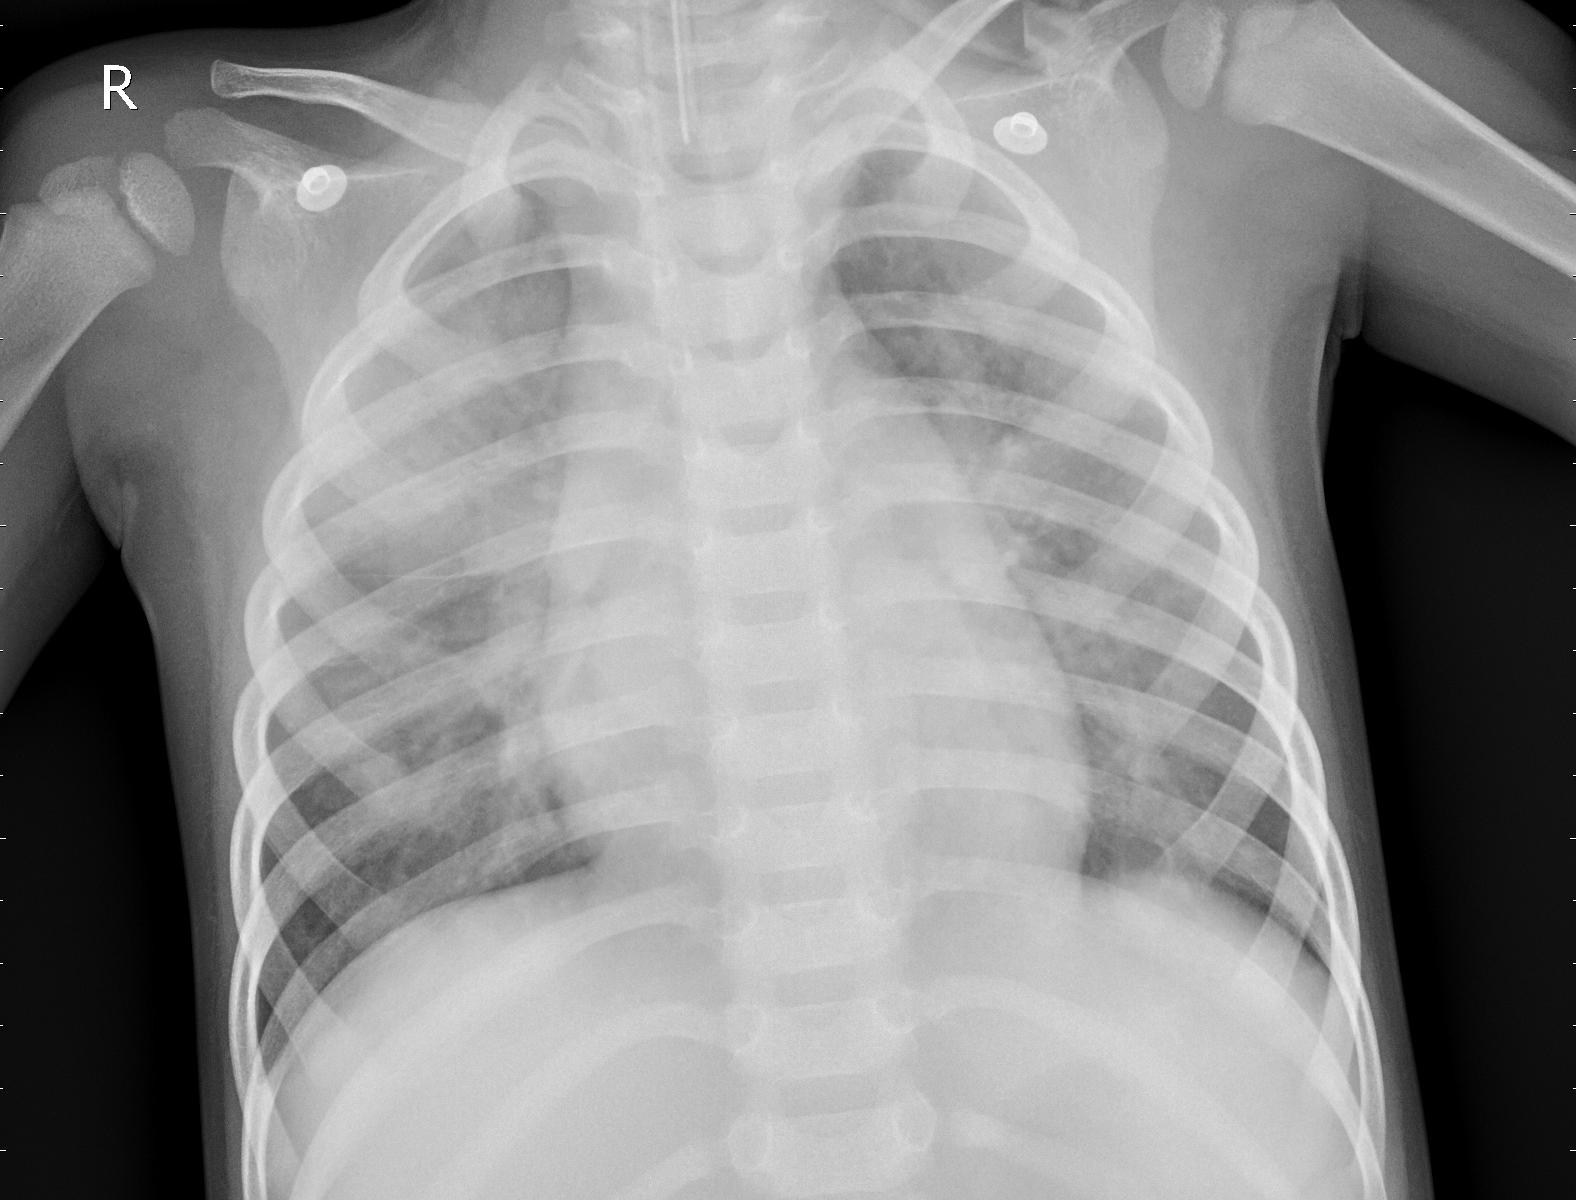

person322_bacteria_1494.jpeg


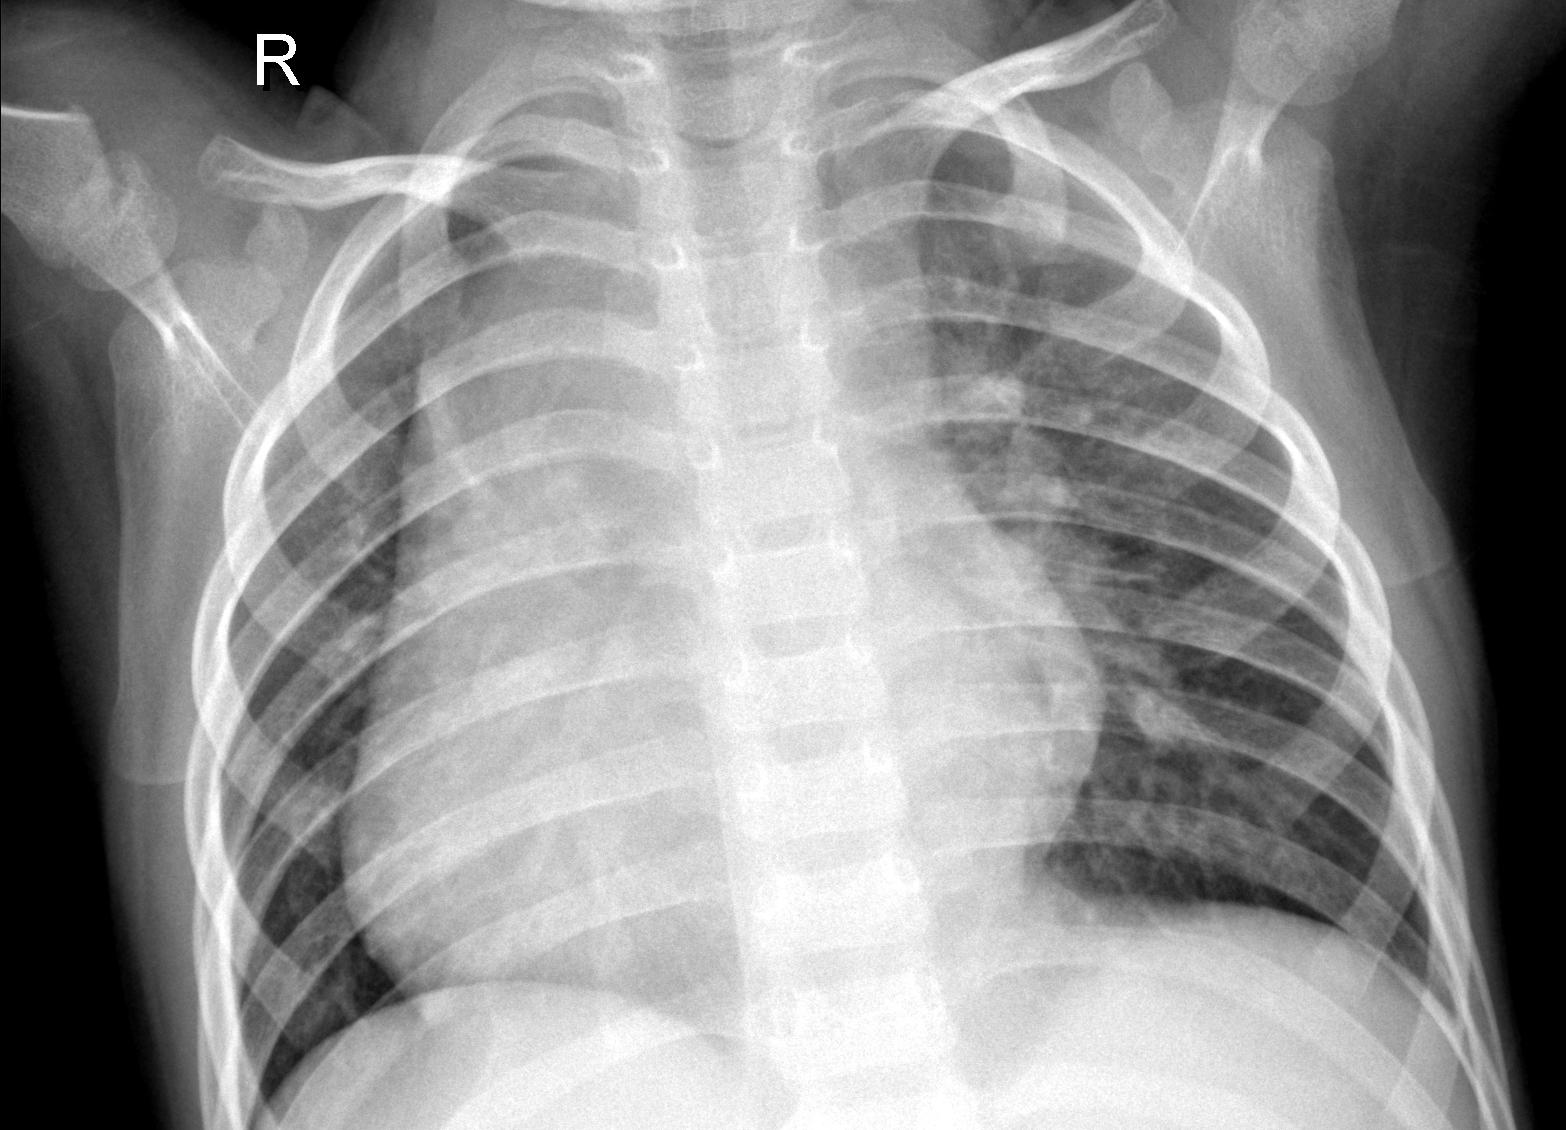

NORMAL2-IM-1152-0001.jpeg


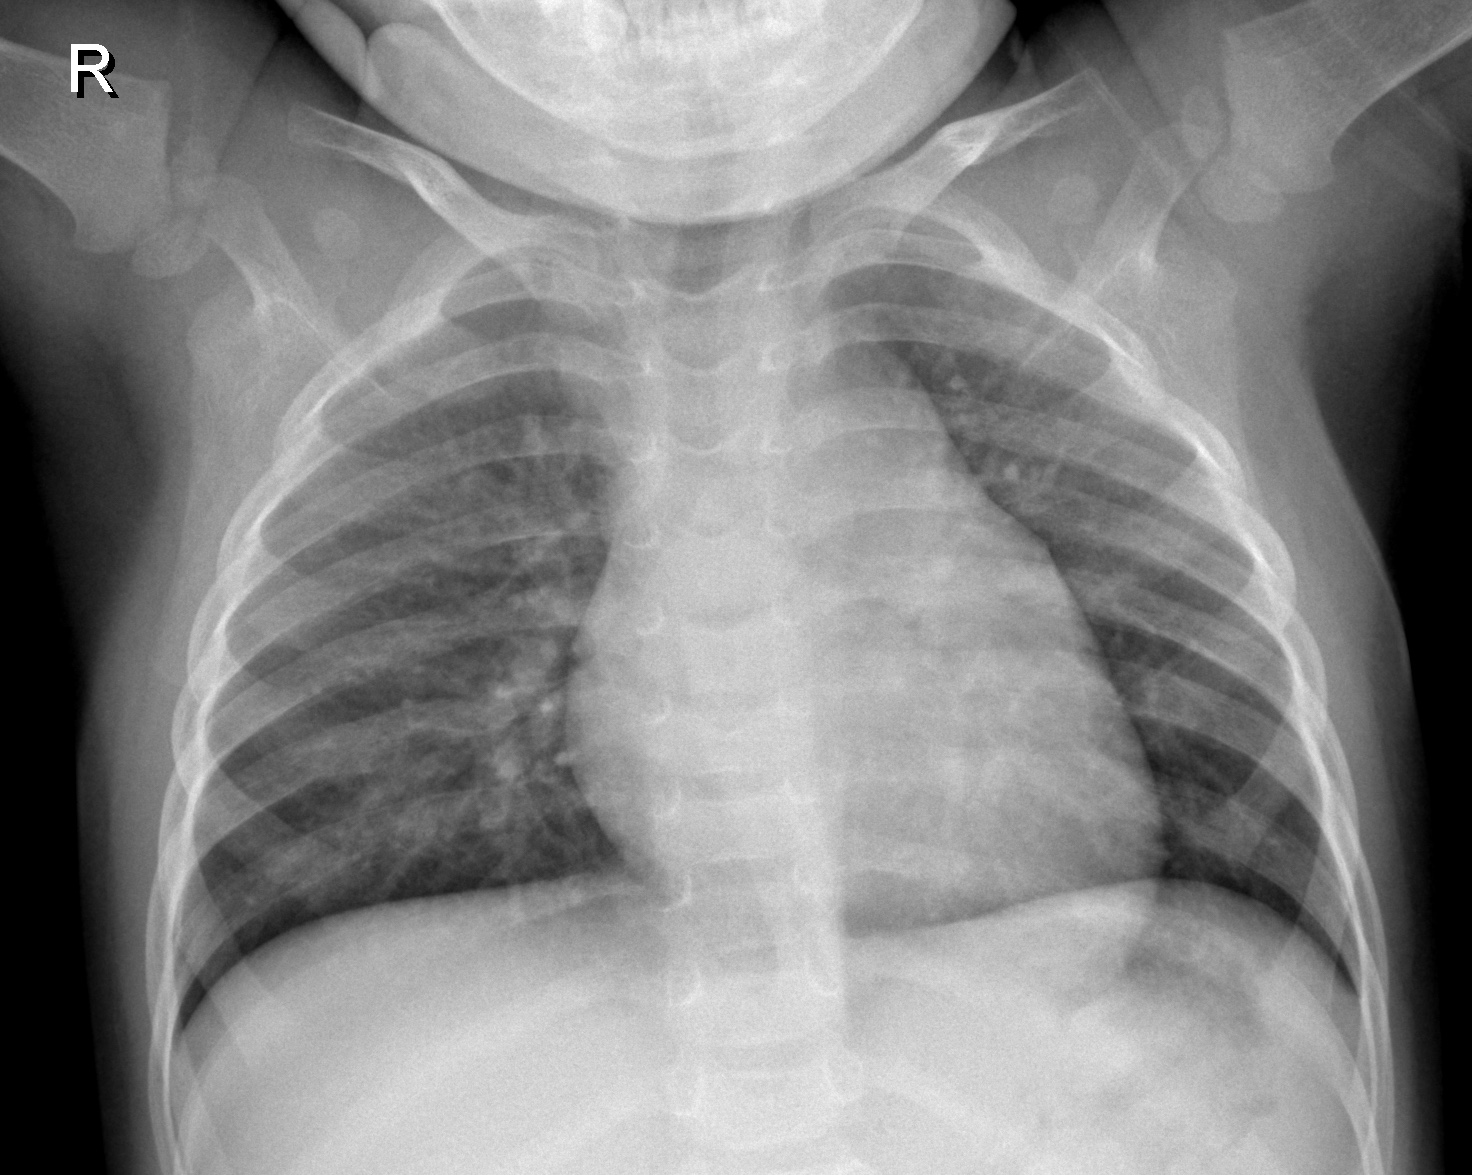

IM-0523-0001.jpeg


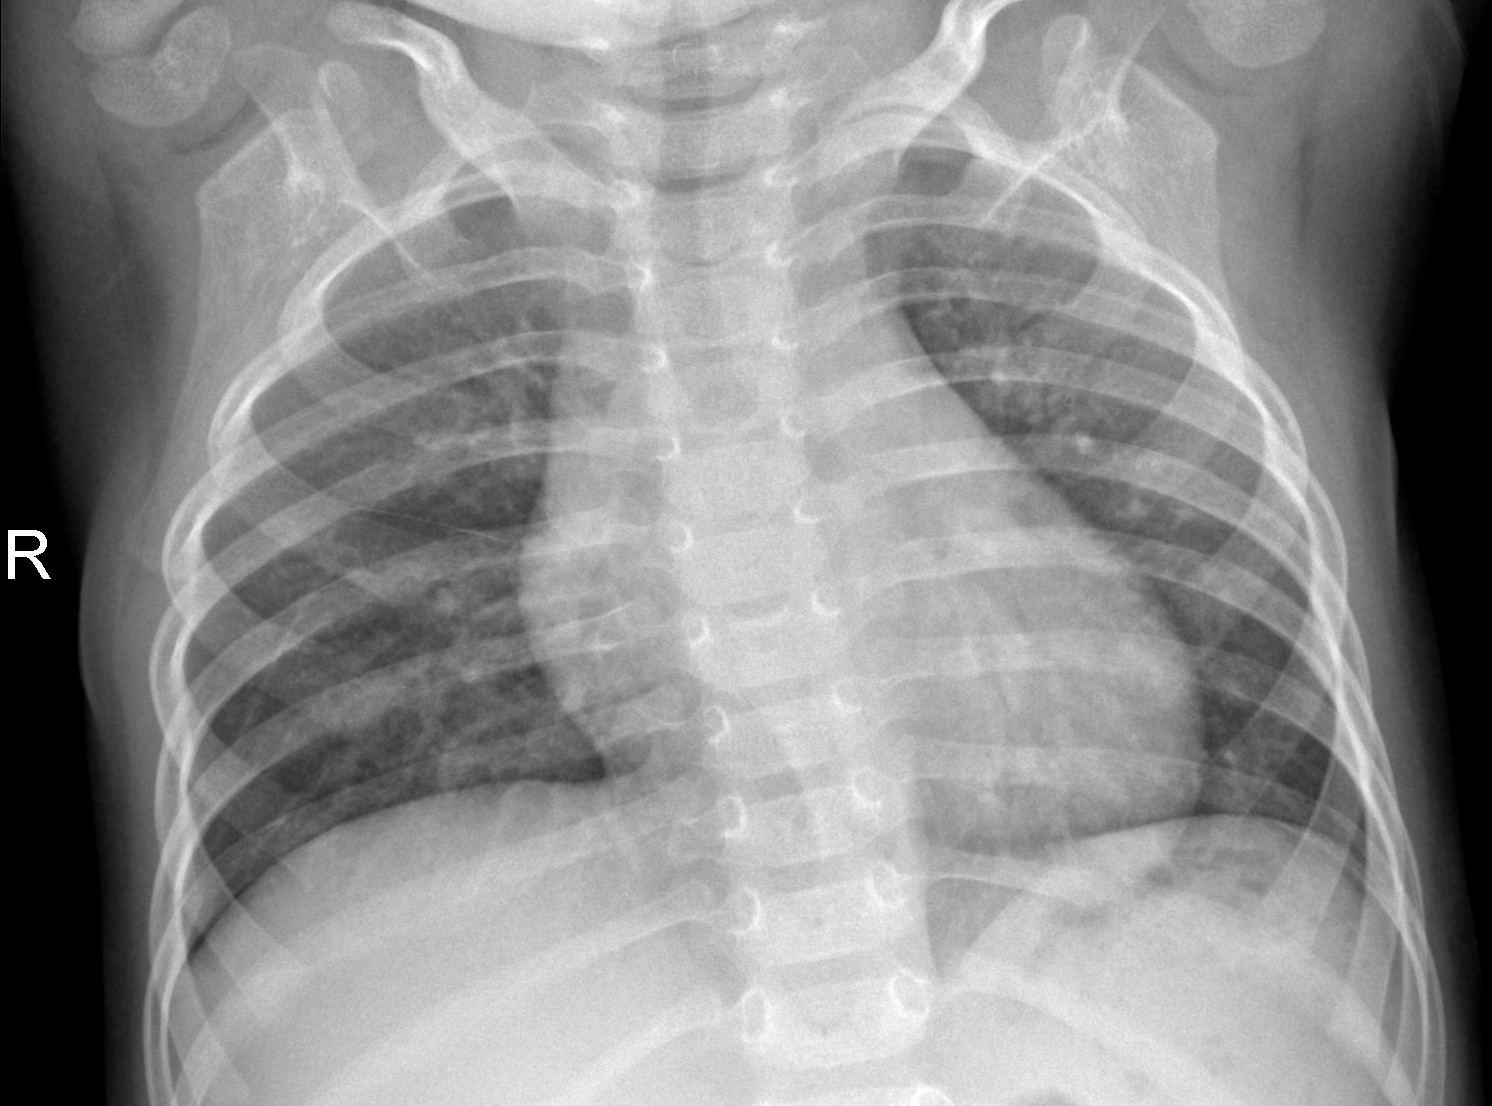

IM-0379-0001.jpeg


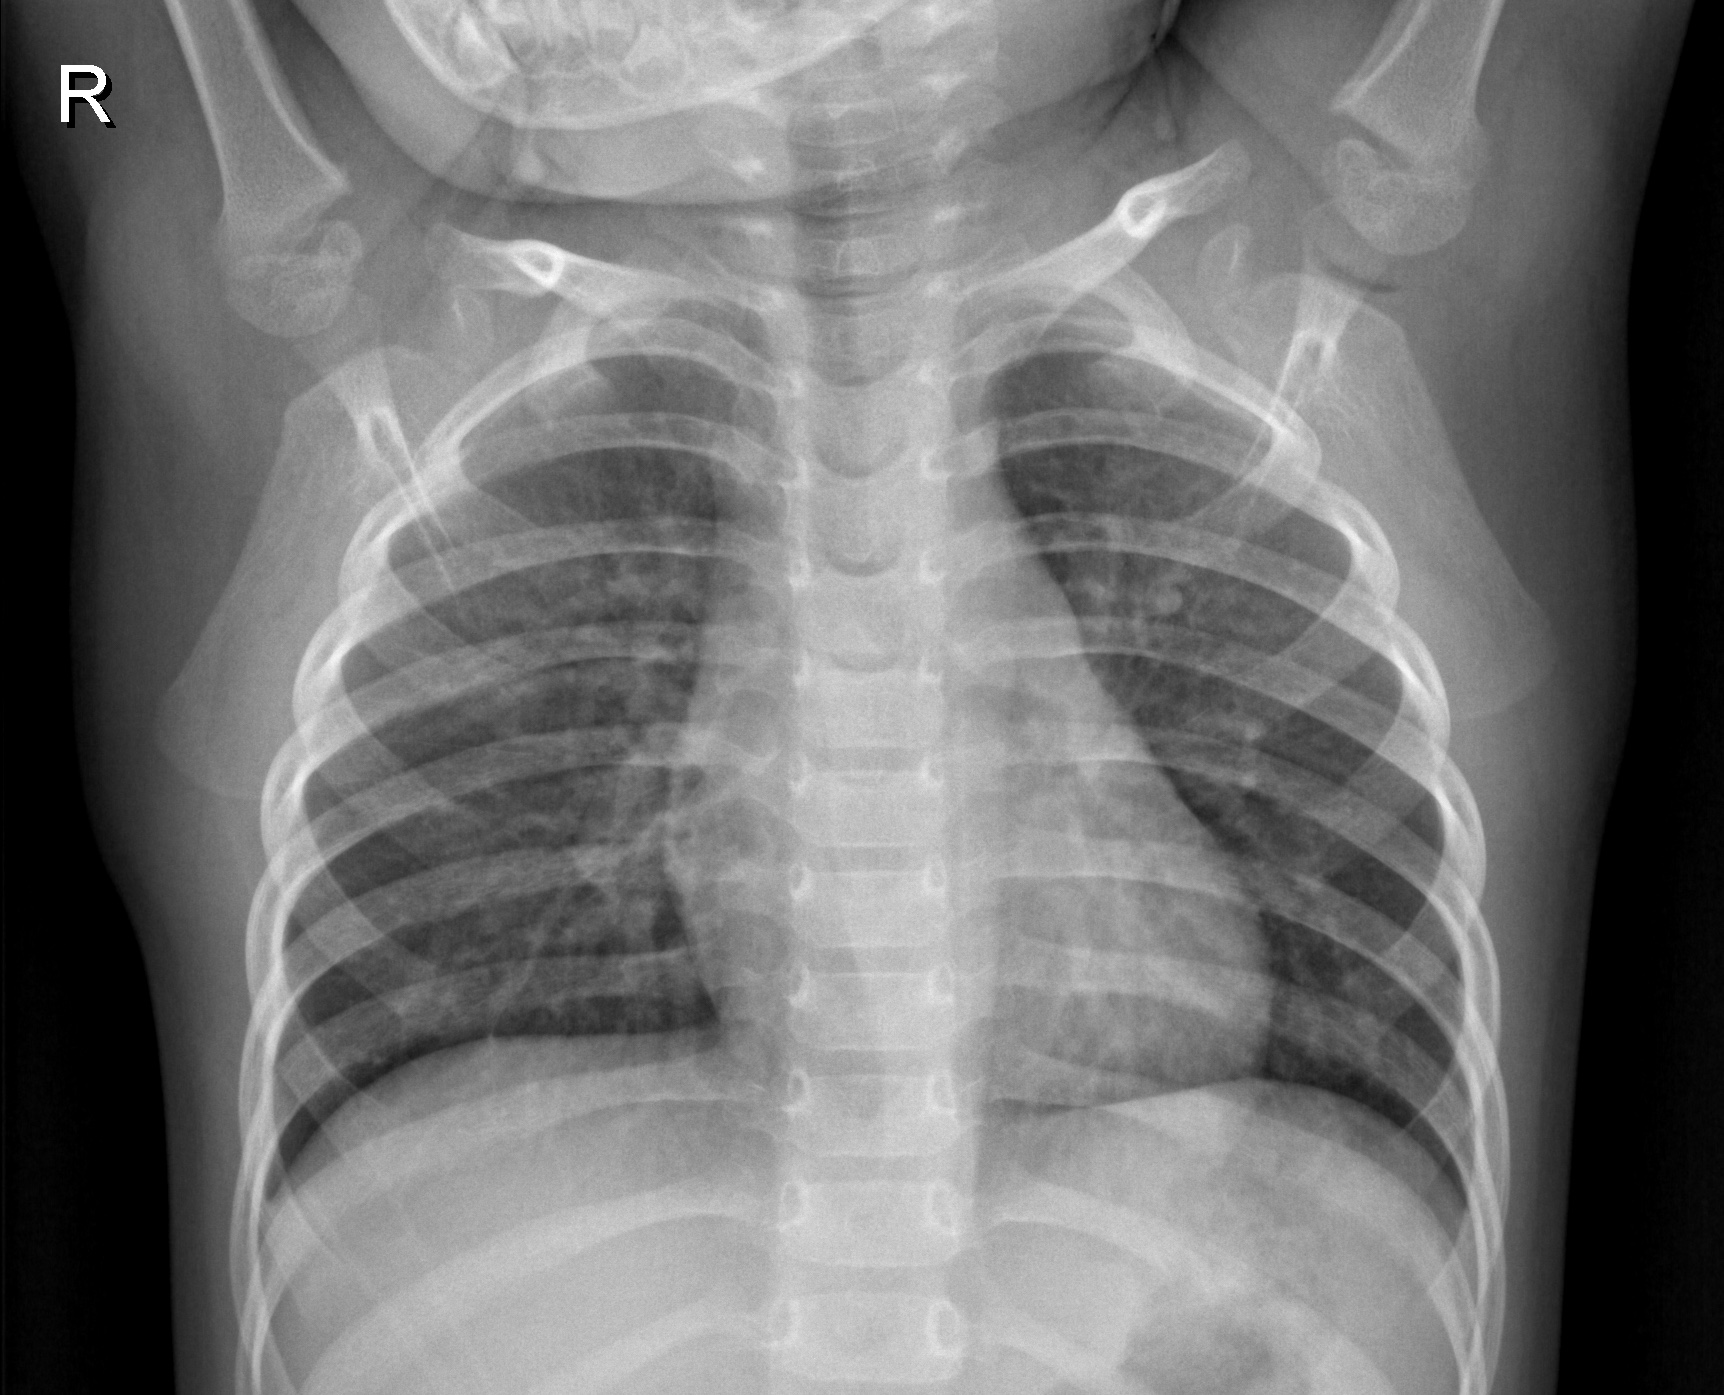

In [4]:
from IPython.display import display
from IPython.display import Image
def images_plot(images,range_low, range_high):
    if ((range_low and range_high) in range(len(normal)) and (range_low < range_high)):
        for i in range(range_low, range_high):
            print(images[i])
            display(Image(filename=folder1 +"/" + images[i], width = 160, height = 240))
    elif ((range_low and range_high) in range(len(normal)+1, len(chest)) and (range_low < range_high)):
        for i in range(range_low, range_high):
            print(images[i])
            display(Image(filename=folder2 +"/" + images[i], width = 160, height = 240))
    else:
        print("Error: Out of Range")
        
images_plot(chest,2364,2367)
images_plot(chest,123,126)

From the images of normal chest and pneumonia, we can hardly tell the differences between them just by insight. It indicates that further analysis of images is essential for this case.

## Pre-processing images

In [5]:
#Code from https://github.com/deadskull7/Pneumonia-Diagnosis-using-XRays-96-percent-Recall/blob/master/Pneumonia%20Diagnosis%20using%20Lung's%20XRay%20.ipynb

def read_data(folder):
    images = []
    labels = [] #Ture status
    for dirc in os.listdir(folder):
        if not dirc.startswith('.'):
            if dirc in ['NORMAL']:
                label = 0
            elif dirc in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            
            readin = folder + dirc
            for image_name in tqdm(os.listdir(readin)):
                img = cv2.imread(readin + '/' + image_name) #Read in images from folder
                if img is not None:
                    img = skimage.transform.resize(img, (160,240,3)) #Resize each image into 160*240
                    img = np.asarray(img) #Turn each image into array
                    images.append(img)
                    labels.append(label)
            
    images = np.asarray(images) 
    labels = np.asarray(labels)
    
    return images,labels

In [6]:
chest_images, chest_ture = read_data(folder)

100%|██████████| 1342/1342 [10:06<00:00,  2.44it/s]


In [8]:
print(chest_images.shape)
print(chest_ture.shape)

(5216, 160, 240, 3)
(5216,)


In [9]:
type(chest_images)

numpy.ndarray

## Convert to Gray Scale


luminance is by far more important in distinguishing visual features. An excellent suggestion to illustrate this property would be: take a given image and separate the luminance plane from the chrominance planes. We will use 0.3*R+0.59*G+0.11*B to convert all the images into gray sclae. Range of grayscale values should spread out between 0 and 255.

In [10]:
def gray_scale(data):
    '''
    input: a np.array of images of rgb format
    output: a np.array of images of grayscale format
    '''
    n_images = data.shape[0]
    n_rows = data.shape[1]
    n_columns = data.shape[2]
    grayscale = np.zeros((n_images, n_rows, n_columns, 1))
    
    for idx in range(n_images):
        grayscale[idx, :, :, 0] = np.add(0.3*data[idx,:,:,0], 0.59*data[idx,:,:,1],
                                        0.2*data[idx,:,:,2])
    return grayscale  

In [11]:
chest_gray = gray_scale(chest_images)

In [12]:
print(chest_gray.shape)

(5216, 160, 240, 1)


## Linearize the Data

In [107]:
def linearize(data):
    '''
    input:a np.array of images
    output: a 2-D np.array(1-D image feature for each row)
    '''
    num_images = data.shape[0]
    num_columns = int(np.prod(data.shape)/num_images)
    
    linear = np.zeros((num_images, num_columns))
    linear = np.reshape(data, (num_images, num_columns))
    return linear

chest_gray_linear = linearize(chest_gray)
chest_rgb_linear = linearize(chest_images)

# Data Reduction (60 Points Total)

# Principal Component Analysis (PCA)

## PCA Equations

Raschka, S. and Mirjalili, V. (n.d.). Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow. 2nd ed. Packt Publishing.

### Feature Reduction:

$$x = \begin{bmatrix}
x_{1} & x_{2} & ... & x_{d}
\end{bmatrix}, x \,  \epsilon \,  \mathbb{R}^{d}$$

$$\downarrow xW, W\epsilon \, \mathbb{R}^{dxk}$$

$$z = \begin{bmatrix}
z_{1} &z_{2}  & ... & z_{k}
\end{bmatrix}, z\, \epsilon \, \mathbb{R}^{k}$$



### Creating the Covariance Matrix (pg 145-pg 146 in Raschka)
$$\sigma _{jk} = \frac{1}{n}\sum_{i = 1}^{n} (x^{(i)}_{j} -\mu _{j})(x_{k}^{(i)} -\mu _{k})$$


$$ \sum = \begin{bmatrix}
\sigma ^{2}_{1} & \sigma _{12} & \sigma _{13} \\ 
 \sigma _{21}& \sigma ^{2}_{2} & \sigma _{23}\\ 
 \sigma _{31}& \sigma _{32} & \sigma ^{2}_{3}
\end{bmatrix} $$

### Find Eigenvalues (pg 146 in Raschka)

$$\varepsilon  v = \lambda v$$

### Total and Explained Variance (pg 147 in Raschka)

$$\frac{\lambda _{j}}{\sum_{j=1}^{d} \lambda _{j}}$$



### Projecting onto new Feature Space (page 162 in Raschka)

$$X^{'} = XW$$

In [14]:
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import SparsePCA

In [15]:
def full_pca(data,n):
    '''
    input:data,n_components
    output: full pca of data
    '''
    chest_pca = PCA(n_components=n)
    return chest_pca.fit(chest_gray_linear)

In [16]:
chest_pca = full_pca(chest_gray_linear,5216)

# Plot individual and cumulative explained variance

In [17]:
def explain_variance(pca):
    '''
    input:pca 
    output: explained variance
    '''
    explained_var = pca.explained_variance_ratio_
    return explained_var

In [18]:
def cumu_variance(pca):
    '''
    input:pca 
    output: cumulative variance
    '''
    cumu_var_exp = np.cumsum(pca.explained_variance_ratio_)
    return cumu_var_exp

In [19]:
cumu_var = cumu_variance(chest_pca)
explained_var = explain_variance(chest_pca)
print(cumu_var)
print(explained_var)

[0.25632606 0.36139141 0.43453036 ... 1.         1.         1.        ]
[2.56326056e-01 1.05065359e-01 7.31389425e-02 ... 9.95989233e-38
 6.28962691e-38 8.13331270e-39]


In [23]:
#pip install cufflinks plotly

In [24]:
#The plot_explained_variance function is adapted from Eric's 04. Dimension Reduction and Images

from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
import plotly 
def plot_explained_variance(var1,var2):  
    plotly.offline.iplot({
    "data": [Scatter(y=var1, name='Explained variance'),
             Scatter(y=var2, name='cumulative explained variance')
        ],
    "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

In [25]:
plot_explained_variance(explained_var,cumu_var)

/Users/xuechenli/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:550: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/Users/xuechenli/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:578: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




Retaining 40 components will get an explained variance ratio of 0.8 and retaining 200 components will get an explained variance ratio of 0.9. Since 200 is at the knee of the graph, it is appropriate for us to using the first 200 components to represent the chest image.

# PCA with first 200 components

In [26]:
chest_pca_first200 = full_pca(chest_gray_linear,200)

# Plot individual and cumulative explained variance ( first 200 components)

In [27]:
cumu_var = cumu_variance(chest_pca_first200)
explained_var = explain_variance(chest_pca_first200)
plot_explained_variance(explained_var,cumu_var)

/Users/xuechenli/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:550: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/Users/xuechenli/anaconda3/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:578: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis




# Reshape with first 200 components

In [28]:
eigen_chest = chest_pca_first200.components_.reshape(200,160,240)

In [29]:
eigen_chest.shape

(200, 160, 240)

In [30]:
#The plot_gallery function is from Eric's 04. Dimension Reduction and Images

import matplotlib.pyplot as plt# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=4, n_col=6):
    """
    input:  image matrix
    output: image gallery 
    """
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

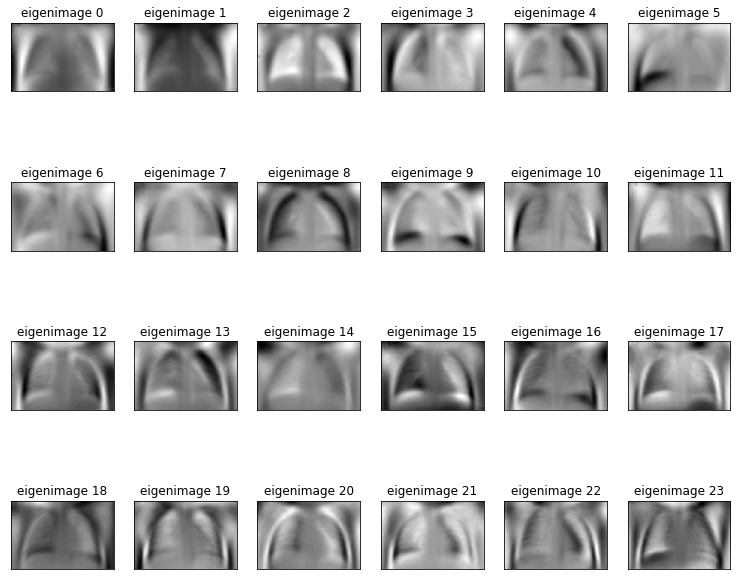

In [31]:
eigenlabels = ['eigenimage ' + str(i) for i in range(eigen_chest.shape[0])]
plot_gallery(eigen_chest,eigenlabels,160,240)

The components represent our images well. The first component reflect the average of the 5216 images

# Compare Original with PCA

In [32]:
#Reconstruct_image function is adapated from Eric's 04 Dimensional Reduction and Images
''' original from Eric
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 131    
chest_gray_linear_idx = chest_gray_linear[idx_to_reconstruct]
low_dim, reconstructed_image = reconstruct_image(chest_pca_first200,chest_gray_linear_idx.reshape(1, -1))
'''
def reconstruct_image(trans_obj,pca_features,idx):
    '''
    input:pca_data,trans_obj,org_features,idx
    output:tranformation of the specific picture
    '''
    low_dim = trans_obj.transform(pca_features[idx].reshape(1,-1))
    rec_image = trans_obj.inverse_transform(low_dim)
    return low_dim, rec_image

In [33]:
chest_gray_linear.shape

(5216, 38400)

In [34]:
chest_pca_first200.components_.shape

(200, 38400)

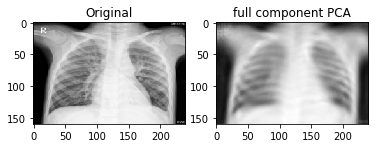

In [35]:
#Make a comparison here
#Take the 100th image as an example
low_dim, rec_image = reconstruct_image(chest_pca_first200,chest_gray_linear,100)

plt.subplot(1,2,1)
plt.imshow(chest_gray_linear[100].reshape(160,240), cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)

plt.subplot(1,2,2)
plt.imshow(rec_image.reshape(160,240), cmap=plt.cm.gray)
plt.title('full component PCA')
plt.grid(False)

# Non-linear PCA: kernal pca (kPCA)

### kPCA (pg 166 in Raschka)

$$\phi: \mathbb{R}^{d}\rightarrow \mathbb{R}^{k} (k >>d)$$

### kPCA Covariance Matrix (pg 168 in Raschka)

$$\sum = \frac{1}{n}\sum_{i = 1}^{n}\phi (x^{(i)})\phi(x^{(i)})^{T}$$

### kPCA Eigenvectors (pg 168 in Raschka)

$$v = \frac{1}{n\lambda }\sum_{i=1}^{n}\phi (x^{(i)})\phi (x^{(i)})^{T}$$

### Kernel Trick (pg. 170 in Raschka)

$$k(x^{(i)}, x^{(j)}) = (\phi x^{(i)}) ^{T}\phi x^{(j)}$$


## Radial Basis PCA

### Radial Basis Function (Gausssian Kernel) (page 170 in Raschka)

$$k(x^{(i)}, x^{(j)}) =exp\left ( - \frac{\left \| x^{(i)} - x^{(j)} \right \|^{2}}{2\sigma ^{2}} \right )$$

In [36]:
def rbf_pca(data, n, gamma):
    '''
    Input: data to run pca on, gamma parameter default is 0.15
    Output: PCA object
    '''
    chest_kpca = KernelPCA(n_components=n,kernel='rbf', 
                    fit_inverse_transform=True, gamma=gamma,
                    remove_zero_eig=True)
    return chest_kpca.fit(data)

We tried running rbf kernel with gamma = 0.15 and it did not converge. So, we tried a smaller gamma of 0.10. With 0.10, we got an answer. But, we will try more gammas to ensure that it converged to the weights with minimal error.

In [37]:
chest_rbf = rbf_pca(chest_gray_linear, 200, 0.10) #gamma=0.1 works

In [38]:
chest_rbf_2 = rbf_pca(chest_gray_linear, 200, 0.05) #we try for gamma=0.05 and it also works

# Polynomial PCA

### Polynomial Kernel (pg. 170 in Raschka)

$$ k(x^{(i)}, x^{(j)}) = ((x^{(i)T}) \: x^{(j)} + \theta)^{p} $$

In [39]:
def poly_pca(data,n,degree,gamma):
    chest_kpca = KernelPCA(n_components=n, kernel='poly', degree= degree,
                    fit_inverse_transform=True, gamma=gamma,
                    remove_zero_eig=True)  
    return chest_kpca.fit(data)

In [40]:
chest_poly = poly_pca(chest_gray_linear,200,2,0.15) 

In [41]:
chest_poly_2 = poly_pca(chest_gray_linear,200,2,0.1)

For degree=2 it works. But it didn't work for degree more than 2, we will have a singular matrix error for degree > 2.

# Sigmoid PCA

### Hyperbolic Tangent (sigmoid Kernel) (page 170 in Raschka)

$$k(x^{(i)}, x^{(j)}) = tanh \,(\eta x^{(i)T} \, x^{(j)} + \theta)$$

In [42]:
def sigmoid_pca(data,n,gamma):
    chest_kpca = KernelPCA(n_components=n, kernel='sigmoid',
                    fit_inverse_transform=True, gamma=gamma,remove_zero_eig=True)  
    return chest_kpca.fit(data)

In [44]:
#chest_sigmoid = sigmoid_pca(chest_gray_linear,200,0.1) 

Sigmoid PCA didn't work as zero eigenvalue creates.

# Cosine PCA

In [43]:
def cosine_pca(data,n):
    chest_kpca = KernelPCA(n_components=n, kernel='cosine',
                    fit_inverse_transform=True,
                    remove_zero_eig=True)  
    return chest_kpca.fit(data)

In [44]:
chest_cosine = cosine_pca(chest_gray_linear,200)

# Reconstruct image with all PCA methods 

In [112]:
#Make a comparison function, select picture id we want to compare
def picture_compare(idx):
    '''
    input:picture id
    output: comparison of image
    '''
    low_dim, rec_image_fpca = reconstruct_image(chest_pca_first200,chest_gray_linear,idx)
    low_dim, rec_image_rbf = reconstruct_image(chest_rbf,chest_gray_linear,idx)
    low_dim, rec_image_poly = reconstruct_image(chest_poly,chest_gray_linear,idx)
    low_dim, rec_image_cosine = reconstruct_image(chest_cosine,chest_gray_linear,idx)

    fig = plt.figure(figsize=(16,24))
    plt.subplot(1,5,1)
    plt.imshow(chest_gray_linear[idx].reshape(160,240), cmap=plt.cm.gray)
    plt.title('Original')
    plt.grid(False)

    plt.subplot(1,5,2)
    plt.imshow(rec_image_fpca.reshape(160,240), cmap=plt.cm.gray)
    plt.title('full component PCA')
    plt.grid(False)

    plt.subplot(1,5,3)
    plt.imshow(rec_image_rbf.reshape(160,240), cmap=plt.cm.gray)
    plt.title('rbf PCA')
    plt.grid(False)


    plt.subplot(1,5,4)
    plt.imshow(rec_image_poly.reshape(160,240), cmap=plt.cm.gray)
    plt.title('poly PCA')
    plt.grid(False)

    plt.subplot(1,5,5)
    plt.imshow(rec_image_cosine.reshape(160,240), cmap=plt.cm.gray)
    plt.title('cosine PCA')
    plt.grid(False)

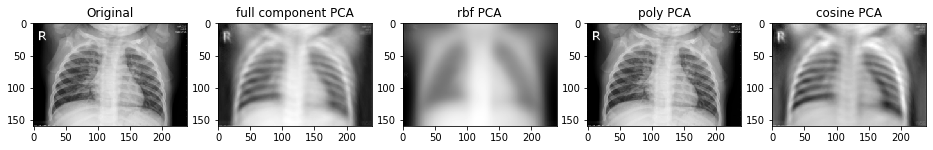

In [113]:
picture_compare(124)

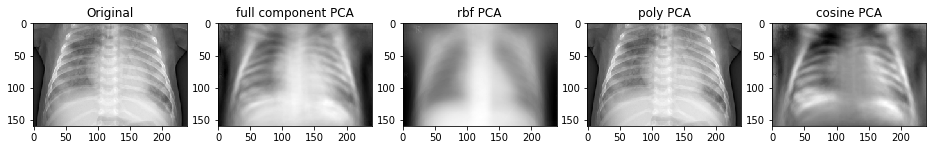

In [123]:
picture_compare(126)

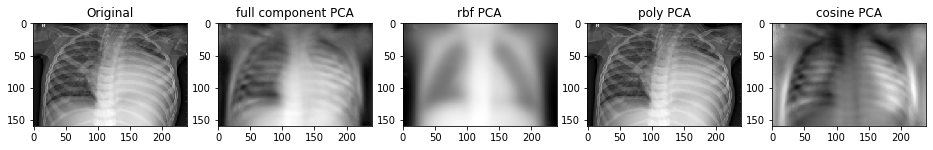

In [124]:
picture_compare(2364)

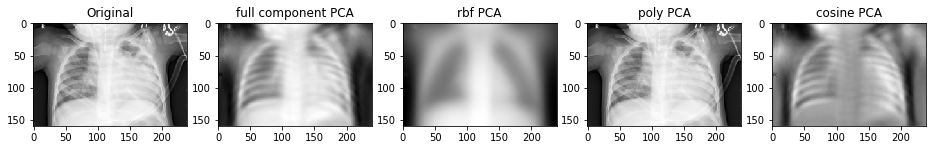

In [125]:
picture_compare(2365)

So using the first 200 components, kernal=polynomial, degree = 2 looks the best with clear details both in the center and contour. Gamma did not change much for the kernal PCA.

# k-Nearest Neighbors (knn) to compare PCA vs. Polynomial

# Split train and test data set

In [165]:
from sklearn.model_selection import train_test_split

In [48]:
#Adapted from https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn
train_data, test_data, train_label, test_label = train_test_split(chest_gray_linear,chest_ture,test_size = 0.2, shuffle = True)

In [166]:
print(train_data.shape)
print(test_data.shape)
print(train_label.shape)
print(test_label.shape)

(4172, 38400)
(1044, 38400)
(4172,)
(1044,)


# Create full PCA Points from first 200 Eigenvectors

In [167]:
train_pca = full_pca(train_data,200)

In [168]:
eigen_train = train_pca.components_

In [169]:
print(eigen_train.shape)

(200, 38400)


In [170]:
eigen_train = np.transpose(eigen_train)

In [171]:
train_pca_200 = train_data @ eigen_train

In [172]:
print(train_pca_200.shape)

(4172, 200)


# Create KNN Classifier for PCA

In [173]:
#Adapted from https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn
# import the necessary packages
from sklearn.neighbors import KNeighborsClassifier
# knn method
def knn_create_classifier(data,label,n):
    '''
    input: data,n_neighbors,leaf_size
    output: knn classify 
    ''' 
    chest_knn = KNeighborsClassifier(n_neighbors= n, algorithm = 'brute')
    return chest_knn.fit(data,label)

# Classify Test points

In [174]:
chest_pca_knn = knn_create_classifier(train_pca_200, train_label, 5)

In [175]:
def knn_classify(classifier, xtest, ytest):
    '''
    Input: classifier, y test data in eigenvector  format , ytrain data
    Output: Accuracy of knn  classifier
    '''
    num_total = np.zeros([2,2])
    
    for idx in range(len(xtest)):
        
        prediction = classifier.predict(xtest[idx:idx+1])
        actual = ytest[idx]
        y_hat = int(prediction[0])
        num_total[actual, prediction] += 1
            
    accuracy = classifier.score(xtest, ytest)
    return accuracy, num_total

## Print Accuracy, Confusion Matrix for PCA

In [176]:
test_eigenvectors_200 = test_data @ eigen_train

In [177]:
pca_accuracy, confusion = knn_classify(chest_pca_knn, test_eigenvectors_200, test_label)
print(pca_accuracy)

# print Confusion Matrix
confusion_string = np.array([['Predicted Normal, Actually Normal', 
                     'Predicted Pneumonia, Actually Normal'], 
                    ['Predicted Normal, Actually Pneumonia', 
                     'Predicted Pnedumonia, Actually Pneumonia']])

#print(confusion_string)
print(confusion)

print('Predicted Normal, Actually Normal: ' + str(int(confusion[0][0])))
print('Predicted Pneumonia, Actually Normal: ' + str(int(confusion[0][1])))
print('Predicted Normal, Actually Pneumonia: ' + str(int(confusion[1][0])))
print('Predicted Pneumonia, Actually Pneumonia: ' + str(int(confusion[1][1])))

0.9386973180076629
[[239.  46.]
 [ 18. 741.]]
Predicted Normal, Actually Normal: 239
Predicted Pneumonia, Actually Normal: 46
Predicted Normal, Actually Pneumonia: 18
Predicted Pneumonia, Actually Pneumonia: 741


Note that although our accuracy appears to be as good as the neural network's accuracy in the paper, we are only trying to solve the two class-case pneumonia or not pneumonia, while they are solving the three accuracy case not penumonia, bacterial pneumonia, or viral pneumonia.

## Create KNN Classifier for Polynomial PCA

In [60]:
train_poly = poly_pca(train_data, 200, 2, 0.15)

In [61]:
train_poly_data =  train_poly.transform(train_data)

In [62]:
print(train_poly_data.shape)

(4172, 200)


In [63]:
chest_kpca_knn = knn_create_classifier(train_poly_data, train_label, 5)

## Find Accuracy, Confusion Matrix for Poly kPCA

In [64]:
test_kpca_data = train_poly.transform(test_data)
kpca_accuracy, confusion = knn_classify(chest_kpca_knn, test_kpca_data, test_label)
print(kpca_accuracy)

# print Confusion Matrix
confusion_string = np.array([['Predicted Normal, Actually Normal', 
                     'Predicted Pneumonia, Actually Normal'], 
                    ['Predicted Normal, Actually Pneumonia', 
                     'Predicted Pnedumonia, Actually Pneumonia']])
#print(confusion_string)
print(confusion)

print('Predicted Normal, Actually Normal: ' + str(int(confusion[0][0])))
print('Predicted Pneumonia, Actually Normal: ' + str(int(confusion[0][1])))
print('Predicted Normal, Actually Pneumonia: ' + str(int(confusion[1][0])))
print('Predicted Pneumonia, Actually Pneumonia: ' + str(int(confusion[1][1])))

0.9329501915708812
[[235.  50.]
 [ 20. 739.]]
Predicted Normal, Actually Normal: 235
Predicted Pneumonia, Actually Normal: 50
Predicted Normal, Actually Pneumonia: 20
Predicted Pneumonia, Actually Pneumonia: 739


Unsuprisingly, the accuracy for polynomial kPCA is basically identical to that of regular PCA when you only use the first 200 components for both.

## Create KNN Classifier for RBF

In [65]:
train_rbf = rbf_pca(train_data, 200, 0.1)

In [66]:
train_rbf_data =  train_rbf.transform(train_data)

In [67]:
print(train_rbf_data.shape)

(4172, 200)


In [68]:
chest_rbf_knn = knn_create_classifier(train_rbf_data, train_label, 5)

## Find Accuracy, Confusion Matrix for RBF kPCA

In [69]:
test_rbf_data = train_rbf.transform(test_data)
#print(ytest_eigenvectors_200.shape)
rbf_accuracy, confusion = knn_classify(chest_rbf_knn, test_rbf_data, test_label)
print(rbf_accuracy)

# print Confusion Matrix
confusion_string = np.array([['Predicted Normal, Actually Normal', 
                     'Predicted Pneumonia, Actually Normal'], 
                    ['Predicted Normal, Actually Pneumonia', 
                     'Predicted Pnedumonia, Actually Pneumonia']])
#print(confusion_string)
print(confusion)

print('Predicted Normal, Actually Normal: ' + str(int(confusion[0][0])))
print('Predicted Pneumonia, Actually Normal: ' + str(int(confusion[0][1])))
print('Predicted Normal, Actually Pneumonia: ' + str(int(confusion[1][0])))
print('Predicted Pneumonia, Actually Pneumonia: ' + str(int(confusion[1][1])))

0.7241379310344828
[[  0. 285.]
 [  3. 756.]]
Predicted Normal, Actually Normal: 0
Predicted Pneumonia, Actually Normal: 285
Predicted Normal, Actually Pneumonia: 3
Predicted Pneumonia, Actually Pneumonia: 756


As a check on our code, we tried to calculate Radial Based PCA as a negative case to see whether it is the worst one among those PCA methods.  From the image analysis, we expect it to be the worst.  Thankfully, it only has an accuracy of 72%.

So comparing PCA and Kernal PCA with the first 200 components, it is clear that the PCA and polynomial PCA 
do the best with more than 95% accuracy, while the Radial Based PCA does the worst, with only 75% accuarcy.

# Histogram of Oriented Gradients (HOG)

https://www.learnopencv.com/histogram-of-oriented-gradients/

The histogram of oriented gradients measures the magnitude and direction of the gradient in "block" sizes that it then shifts across the image. 

### Magnitude of Gradient

$$g = \sqrt{g^{2}_{x} + g^{2}_{y}}$$

https://www.learnopencv.com/histogram-of-oriented-gradients/

### Direction of Gradient

$$\theta = tan^{-1}\frac{g_{y}}{g_{x}}$$

https://www.learnopencv.com/histogram-of-oriented-gradients/

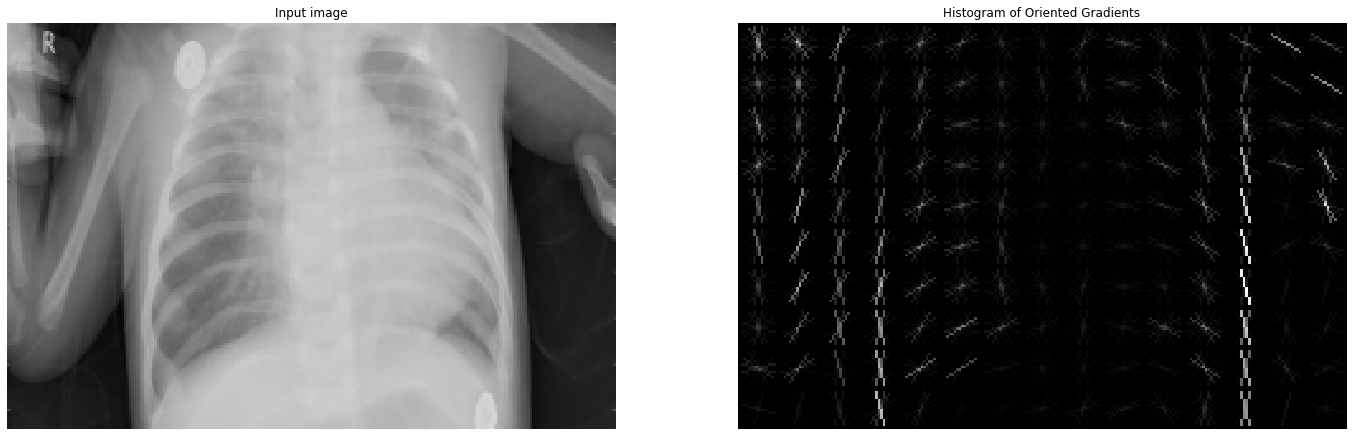

In [130]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

# following code copied from https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

fd, hog_chest = hog(chest_images[8], orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(chest_images[8], cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_chest_rescaled = exposure.rescale_intensity(hog_chest, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_chest_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [131]:
# following code copied from https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
def plot_oriented_gradients(image, pixels_per_cell, cells_per_block):
    '''
    Input: image as matrix, pixels per cell as tuple, cells per block as tuple
    Output: plot the original image, HOG image
    '''
    fd, hog_chest = hog(image, orientations=8, pixels_per_cell= pixels_per_cell,
                    cells_per_block= cells_per_block, visualize=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 16), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(image, cmap=plt.cm.gray)
    ax1.set_title('Input image')

    # Rescale histogram for better display
    hog_chest_rescaled = exposure.rescale_intensity(hog_chest, in_range=(0, 10))

    ax2.axis('off')
    ax2.imshow(hog_chest_rescaled, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    plt.show()

From the description of pneumonia, we want a block size that is large enough to "see" the increased lung.  Thus, we want a medium-size block size.  So, we pick 16x16. 16x16 is also the size chosen in the learnopencv.com/histogram-of-oriented-gradients tutorial.  Though they are using HOG to identify pedestrians, this is probably a good size for us as well.

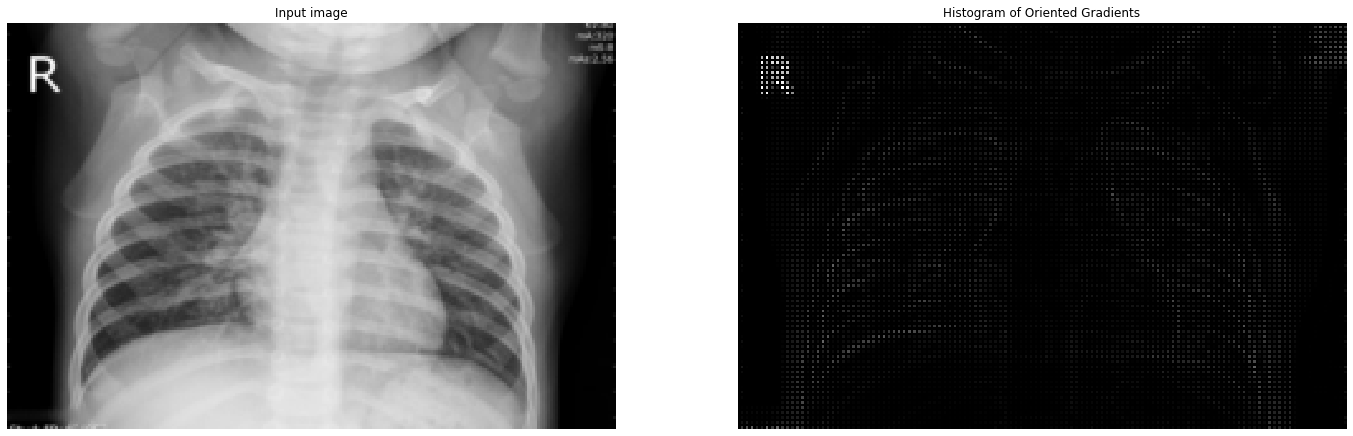

In [135]:
ppc = (2,2)
cells_per_block = (1,1)
image = chest_images[124]
plot_oriented_gradients(image, ppc, cells_per_block)

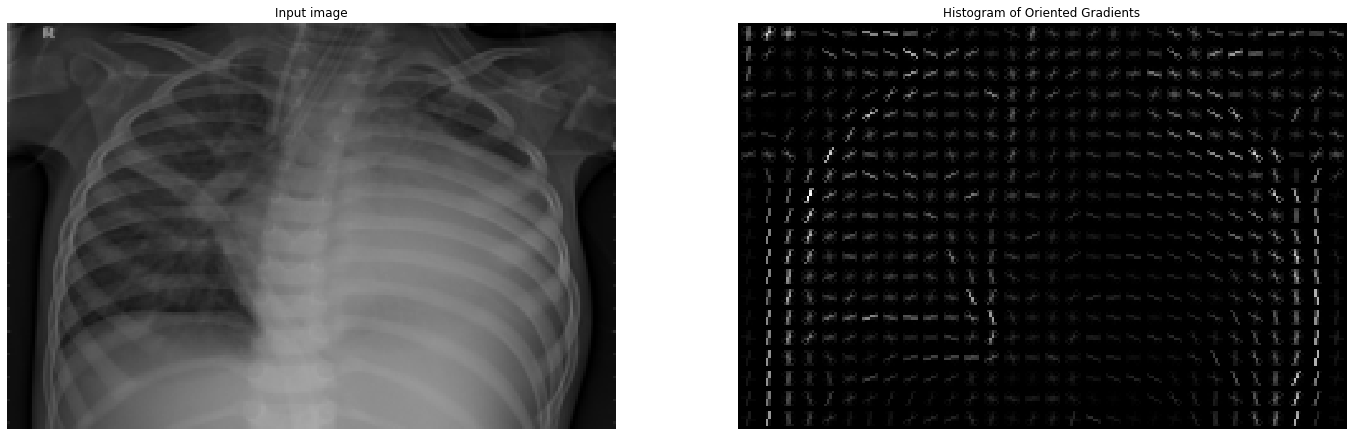

In [136]:
ppc = (8,8)
cells_per_block = (1,1)
image = chest_images[2364]
plot_oriented_gradients(image, ppc, cells_per_block)

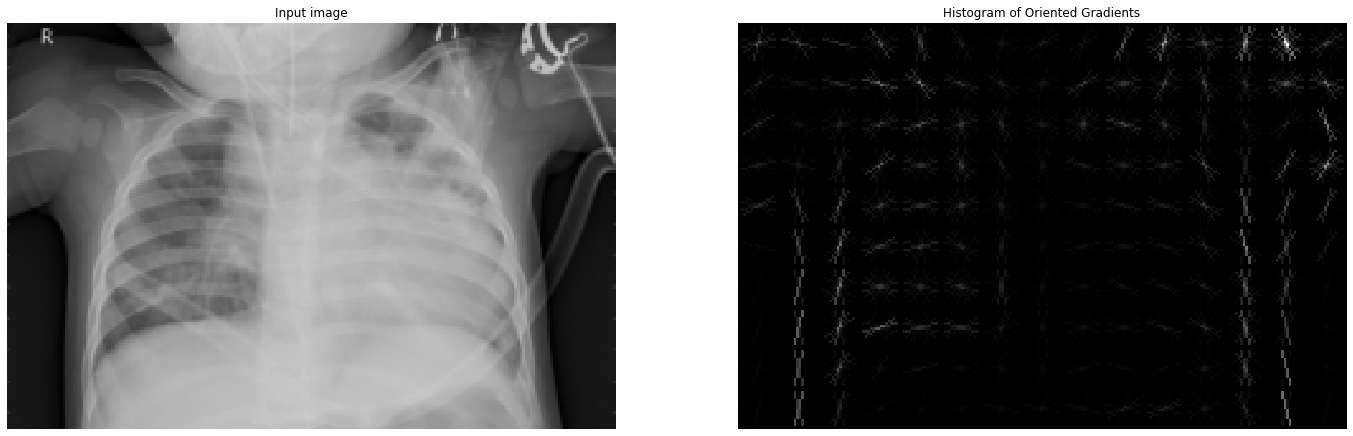

In [137]:
ppc = (16,16)
cells_per_block = (1,1)
image = chest_images[2365]
plot_oriented_gradients(image, ppc, cells_per_block)

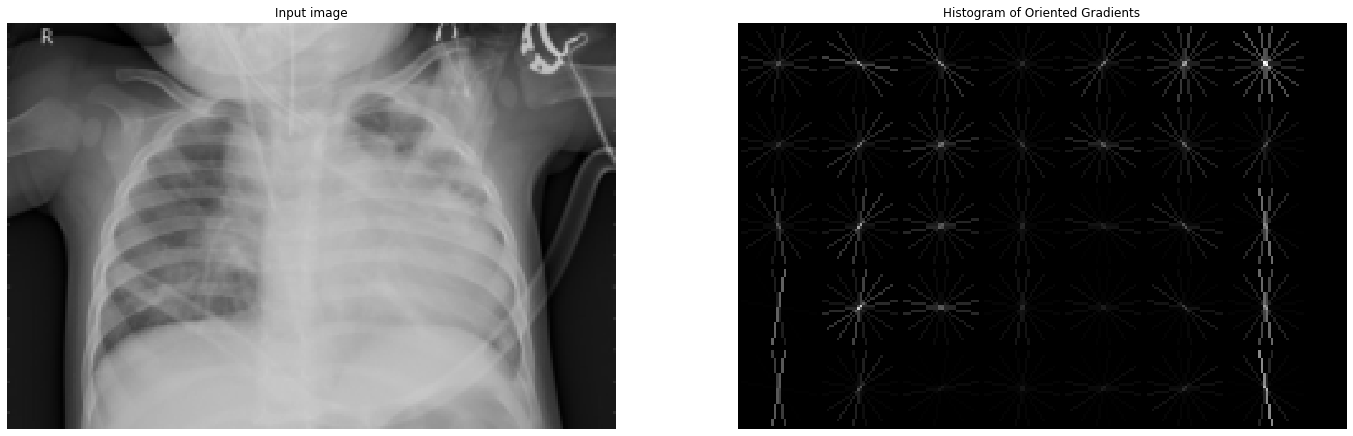

In [140]:
ppc = (32,32)
cells_per_block = (1,1)
image = chest_images[2365]
plot_oriented_gradients(image, ppc, cells_per_block)

In [108]:

def oriented_gradients(images, pixels_per_cell, cells_per_block):
    '''
    Input: images as x matrices, pixels per cell as tuple, cells per block as tuple
    Output: HOG images
    '''
    X = []   
    # print out percent progress evey 10 percent

    num_images = len(images)
    for idx, image in enumerate(images):
        #new_digit = np.floor(idx / num_images)
        #if new_digit % 10 == 0:
        #    print(str(new_digit)+'%')
        
        # following line adapted from https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
        hog_linear = hog(image, orientations=8, pixels_per_cell= pixels_per_cell,
                         cells_per_block = cells_per_block, feature_vector=True)
        
        X.append(hog_linear)
    return X

In [111]:
ppc = (16,16)
cells_per_block = (1,1)
train_data_hog = oriented_gradients(train_data.reshape((len(train_data), 160, 240)), ppc, cells_per_block)
test_data_hog = oriented_gradients(test_data.reshape((len(test_data), 160,240)), ppc, cells_per_block)

In [150]:
#print(len(train_data_hog))
#print(len(test_data_hog))

#print(len(train_data_hog[0]))
#print(len(test_data_hog[0]))

In [151]:
chest_hog_pca = PCA(200)
train_pca = chest_hog_pca.fit(train_data_hog, 200)

In [152]:
eigen_train = train_pca.components_

In [154]:
#print(eigen_train.shape)

In [118]:
eigen_train = np.transpose(eigen_train)

In [155]:
#print(eigen_train.shape)

In [120]:
train_hog_200 = train_data_hog @ eigen_train

In [121]:
chest_hog_knn = knn_create_classifier(train_hog_200, train_label, 5)

In [122]:
test_eigenvectors_200 = test_data_hog @ eigen_train

hog_accuracy, confusion = knn_classify(chest_hog_knn, test_eigenvectors_200, test_label)
print(hog_accuracy)
#print(confusion)

# print Confusion Matrix
confusion_string = np.array([['Predicted Normal, Actually Normal', 
                     'Predicted Pneumonia, Actually Normal'], 
                    ['Predicted Normal, Actually Pneumonia', 
                     'Predicted Pnedumonia, Actually Pneumonia']])
#print(confusion_string)
print(confusion)

print('Predicted Normal, Actually Normal: ' + str(int(confusion[0][0])))
print('Predicted Pneumonia, Actually Normal: ' + str(int(confusion[0][1])))
print('Predicted Normal, Actually Pneumonia: ' + str(int(confusion[1][0])))
print('Predicted Pneumonia, Actually Pneumonia: ' + str(int(confusion[1][1])))

0.9425287356321839
[[245.  40.]
 [ 20. 739.]]
Predicted Normal, Actually Normal: 245
Predicted Pneumonia, Actually Normal: 40
Predicted Normal, Actually Pneumonia: 20
Predicted Pneumonia, Actually Pneumonia: 739


With a block size of 16x16, we match the accuracy of PCA and polynomial PCA while we handily beat the accuracy or RBF kPCA.

# Exceptional Work (10 Points total)

# Scale Invariant Feature Transform (SIFT) 

# The algorithm

SIFT is quite an involved algorithm. It has a lot going on and can become confusing, So we've split up the entire algorithm into multiple parts. Here's an outline of what happens in SIFT.

1.Constructing a scale space This is the initial preparation. We create internal representations of the original image to ensure scale invariance. This is done by generating a "scale space".

2.LoG Approximation The Laplacian of Gaussian is great for finding interesting points (or key points) in an image. But it's computationally expensive. So we cheat and approximate it using the representation created earlier.

3.Finding keypoints With the super fast approximation, we now try to find key points. These are maxima and minima in the Difference of Gaussian image we calculate in step 2.

4.Get rid of bad key points Edges and low contrast regions are bad keypoints. Eliminating these makes the algorithm efficient and robust. A technique similar to the Harris Corner Detector is used here.

5.Assigning an orientation to the keypoints An orientation is calculated for each key point. Any further calculations are done relative to this orientation. This effectively cancels out the effect of orientation, making it rotation invariant.

6.Generate SIFT features Finally, with scale and rotation invariance in place, one more representation is generated. This helps uniquely identify features. Lets say we have 50,000 features. With this representation, we can easily identify the feature we're looking for (say, a particular eye, or a sign board). That was an overview of the entire algorithm. Over the next few days, we'll go through each step in detail. Finally, we'll show how to implement SIFT in OpenCV!



Equations taken from following tutorial:
http://aishack.in/tutorials/sift-scale-invariant-feature-transform-log-approximation/

### Blurring

http://aishack.in/tutorials/sift-scale-invariant-feature-transform-scale-space/

$$ L_{blurred \, image}(x,y,\sigma ) = G_{Gaussian\, blur \, operator}(x,y,\sigma) *I_{image}(x,y) $$

### Gaussian Blur Operator

http://aishack.in/tutorials/sift-scale-invariant-feature-transform-scale-space/


$$G_{Gaussian\, blur \, operator}(x,y,\sigma) = \frac{1}{2\pi \sigma ^{2}}e^{-(x^{2}+y^{2})/2\sigma ^{2}}$$

### Subpixel Maxima/minima

http://aishack.in/tutorials/sift-scale-invariant-feature-transform-keypoints/

$$D(x) = D + \frac{\delta D^{T}}{\delta x}x + \frac{1}{2}x^{T}\frac{\delta ^{2}D}{\delta x^{2}}x$$


### Gradient Magnitudes

http://aishack.in/tutorials/sift-scale-invariant-feature-transform-keypoint-orientation/

$$m(x,y) = \sqrt{(L(x+1,y)-L(x-1,y))^{2}+L(x,y+1)-L(x,y-1))^{2}}$$

### Gradient Angles

http://aishack.in/tutorials/sift-scale-invariant-feature-transform-keypoint-orientation/

$$\theta(x,y) = tan^{-1}{\left ( \frac{L(x, y+1)-L(x,y-1)}{L(x+1,y)-L(x-1,y)}\right )}$$


# Install modules

In [11]:
##Since SIFT is not available in opencv now, we installed the previous vision.
#pip install opencv-contrib-python==3.4.2.16

# Read in all the images

First, we readin all the images.There are 1341 normal images and 3875 pneumonia images. To avoid computing time, we resized each image into 240*160.

In [88]:
import glob
# Load all the normal images
all_images_normal = []
titles_normal = []
for f in glob.iglob("/Users/xuechenli/Downloads/lessons/7324/lab2/chest_train/NORMAL/*"):
    img = cv2.imread(f)
    image = cv2.resize(img, (240, 160)) #Resize each image into 240*160
    titles_normal.append(f)
    all_images_normal.append(image)

In [89]:
len(all_images_normal)

1341

In [90]:
# Load all the pneumonia images
all_images_pneumonia = []
titles_pneumonia = []
for f in glob.iglob("/Users/xuechenli/Downloads/lessons/7324/lab2/chest_train/PNEUMONIA/*"):
    img = cv2.imread(f)
    image = cv2.resize(img, (240, 160)) #Resize each image into 240*160
    titles_pneumonia.append(f)
    all_images_pneumonia.append(image)

In [91]:
len(all_images_pneumonia)

3875

In [92]:
all_images = all_images_normal + all_images_pneumonia

In [93]:
len(all_images)

5216

After we finished loading all the images, we found all the descriptors for each image.

In [1]:
import cv2
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

In [94]:
# Create input variables for all images
kp_all_images = []
des_all_images = []
for image in all_images:
    kp_all, des_all = sift.detectAndCompute(image,None)
    kp_all_images.append(kp_all)
    des_all_images.append(des_all)

In [95]:
# Create input variables to classification function
# Create input variables for normal, sick
kp_normal = []
des_normal = []
for image1 in all_images_normal:
    kp1_normal, des1_normal = sift.detectAndCompute(image1,None)
    kp_normal.append(kp1_normal)
    des_normal.append(des1_normal)

kp_sick = []
des_sick = []
for image2 in all_images_pneumonia:
    kp1_sick, des1_sick = sift.detectAndCompute(image2,None)
    kp_sick.append(kp1_sick)
    des_sick.append(des1_sick)

# Compare just Two Images (helper function for classification)

Next, we created a compar_kp function to use Matcher.match() method to get the best matches in two images. We defined good matches(with low distance). Then we counted the number of good match points and all points.

In [96]:
def compare_kp(kp_1, des_1, kp_2, des_2):
    '''
    input: kp for two images
    Output: number of keypoints that match, maximum number of matches
    '''
    bf = cv2.BFMatcher()
    # Match descriptors.
    matches = bf.knnMatch(des_1,des_2,k=2) 
    good_points = []
    all_points = 0
    all_points_alt = len(kp_1) if len(kp_1) < len(kp_2) else len(kp_2)
    for m, n in matches:
        all_points += 1
        if m.distance < 0.75*n.distance:
            good_points.append(m)
            
    return len(good_points), all_points

good_point, all_point = compare_kp(kp_sick[0], des_sick[0], kp_normal[0], des_normal[0])
print(good_point)
print(all_point)

5
123


# Compare Each Images using SIFT, Classify ALL Images

At this time, we could do the classification. We compared each target image with all the images, then counted the total number of key points, the numbers of good matches points separately for normal group and pneumonia group. After calculated the ratio of number of good matches points to total key points in each group, we classified the target image into the group with higher ratio.

In [97]:
def create_SIFT_classification(kp_all, des_all, kp_normal, des_normal, kp_sick, des_sick):
    '''
    Input: 5000+ num SIFT features array for all images, normal, and sick
    Output: list of classifications in normal, sick order
    '''
    classification = [] 
    
    # Loop through all images
    num_all_images = len(kp_all)
    for image in range(num_all_images):
        
        # loop through normal images
        num_keypoint_normal = 0
        num_keypoint_normal_all = 0
        
        num_normal_images = len(kp_normal)
        for normal in range(num_normal_images):
        
            num_normal, num_possible = compare_kp(kp_all[image], des_all[image], kp_normal[normal], des_normal[normal])
            # update number of keypoints for normal
            num_keypoint_normal += num_normal
            num_keypoint_normal_all += num_possible
        
        # loop through pneumonia images
        num_keypoint_sick = 0
        num_keypoint_sick_all = 0
        
        num_sick_images = len(kp_sick[0])
        for sick in range(num_sick_images):
            num_sick, num_possible = compare_kp(kp_all[image], des_all[image], kp_sick[sick], des_sick[sick])
            # update number of keypoints for sick
            num_keypoint_sick += num_sick
            num_keypoint_sick_all += num_possible
        
        ratio_normal = num_keypoint_normal/num_keypoint_normal_all
        ratio_sick = num_keypoint_sick/num_keypoint_sick_all

        # Classify original image and append
        if (ratio_normal > ratio_sick):
            classification.append("normal")
        else:
            classification.append("pneumonia")
    return classification

In [ ]:
sift_classification = create_SIFT_classification(kp_all_images, des_all_images,kp_normal, des_normal, kp_sick, des_sick)

We would not run the code again here, since the classification is time-consuming. Instead, we uploaded the csv from our previous results.

In [98]:
#Write array into csv to save running time and check the results
#chest_sift_classification = pd.DataFrame(sift_classification)
#chest_sift_classification.to_csv('/Users/xuechenli/Downloads/lessons/7324/lab2/chest_sift_classification.csv',index=False)
#Read classification
sift_classification = pd.read_csv('/Users/xuechenli/Downloads/lessons/7324/lab2/chest_sift_classification.csv')

In [143]:
#sift_classification.head()

In [144]:
#print(sift_classification["0"][0:1341].value_counts())
#print(sift_classification["0"][1341:5216].value_counts())

In [149]:
confusion = np.array([[1335, 6],
             [2066, 1809]])
accuracy = (1335+1809)/(1341+3875)

print('Accuracy: ' + str(accuracy))
print(confusion)
print('Predicted Normal, Actually Normal: ' + str(int(confusion[0][0])))
print('Predicted Pneumonia, Actually Normal: ' + str(int(confusion[0][1])))
print('Predicted Normal, Actually Pneumonia: ' + str(int(confusion[1][0])))
print('Predicted Pneumonia, Actually Pneumonia: ' + str(int(confusion[1][1])))

Accuracy: 0.602760736196319
[[1335    6]
 [2066 1809]]
Predicted Normal, Actually Normal: 1335
Predicted Pneumonia, Actually Normal: 6
Predicted Normal, Actually Pneumonia: 2066
Predicted Pneumonia, Actually Pneumonia: 1809


We can tell from the results that the accuracy of normality diagnosis is high,1335/1341=99.55%, which means that almost no patient is mis-diagnosed. But the accuracy of pneumonia diagnosis is not so satisfactory, 2066/3875=53.33%, which indicates we need to impove the algorithm, like resize to larger size, the defination of good match points. After we try to run the algorithm with orginal full size images, the accuracy of pneumonia increase to 72.1%.

In [ ]:
###
#Check about accuracy
num_true_normal = 0
num_true_sick = 0
for i in range(len(all_images_normal)):
    if (sift_classification[i] == "normal"):
        num_true_normal += 1
for i in range(len(all_images_normal), len(all_images)):
    if (sift_classification[i] == "pneumonia"):
        num_ture_normal += 1

        
accuracy = num_ture/len(all_images)
accuracy_normal = num_ture_normal/len(all_images_normal)
accuracy_pneumonia = num_ture_pneumonia/len(all_images_pneumonia)

# Show Example of One Image

We can also find the most similar image for special image. We compared this photo with all the images and found the most similar image besides itself.

In [104]:
#Code adapted from https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
#Take a normal image as an example

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
              
# find the keypoints and descriptors with SIFT
original = all_images_normal[863]
kp1, des1 = sift.detectAndCompute(original,None)

similarity = []    
for image_to_compare in all_images:       
    
    # Check for similarities between the 2 images
    kp2, des2 = sift.detectAndCompute(image_to_compare, None)
    # create BFMatcher object
    bf = cv2.BFMatcher()
    # Match descriptors.
    matches = bf.knnMatch(des1,des2,k=2) 
    good_points = []
    for m, n in matches:
        if m.distance < 0.75*n.distance:
            good_points.append(m)
            
    number_keypoints = 0
    if len(kp1) >= len(kp2):
        number_keypoints = len(kp1)
    else:
        number_keypoints = len(kp2)
        
    percentage_similarity = len(good_points) / number_keypoints * 100
    similarity.append(percentage_similarity)

In [105]:
#Since the most similar image would be the image, we define the second most image as the best fit.
most_similar = sorted(similarity)[-2]
most_similar_index = similarity.index(most_similar)
print("Image: " + str(most_similar_index) + "\n")
print("Similarity: " + str(int(most_similar)) + "\n")

Image: 838

Similarity: 19



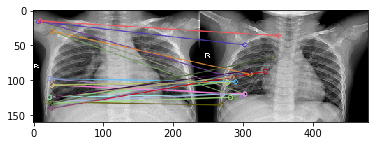

(<matplotlib.image.AxesImage at 0x926667da0>, None)

In [106]:
# Draw the most matches
kp1, des1 = sift.detectAndCompute(original,None)
kp2, des2 = sift.detectAndCompute(all_images[most_similar_index],None)
# Display the most 10 matches
img3 = cv2.drawMatchesKnn(original,kp1,all_images[most_similar_index],kp2,matches[:10],None,flags=2) 
plt.imshow(img3),plt.show() 

# Conclusion

We performed data pre-processing, PCA, kPCA using various kernels, HOG, and SIFT on x-ray images.  We found the best accuracy of 93% using PCA or polynomial kPCA.  For a future lab, we will attempt to separate out bacterial pneumonia and viral pneumonia.